/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


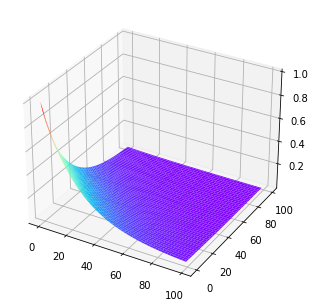

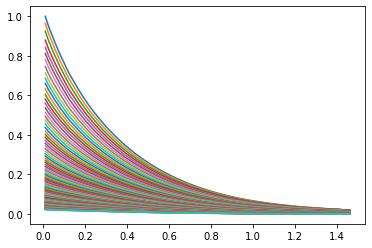

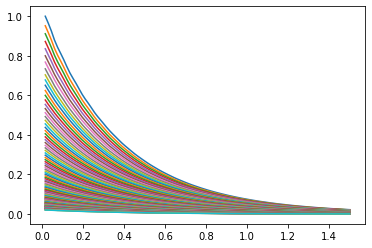

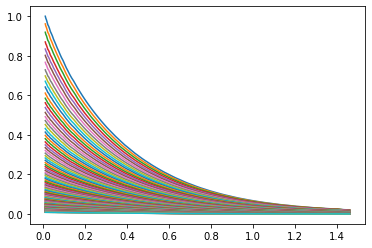

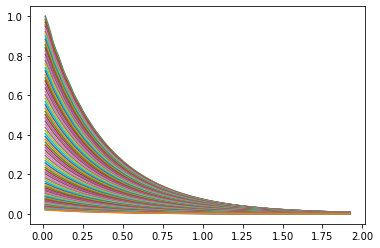

In [63]:
import scipy.io as scio
import numpy as np
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ori_data = scio.loadmat('Dataset/laplace2D_net_input.mat')
b = ori_data['b']
t = ori_data['t']
# laplace2D_net_input = ori_data['S']

# t = t * 3 / 4
# b = b * 5
x, y = np.meshgrid(t, b)
# x_new = np.linspace(np.min(t), np.max(t), 100)
x_new = np.linspace(np.min(t), 1.5, 100)
y_new = np.linspace(np.min(b), np.max(b), 100)
# y_new = np.linspace(np.min(b), 1, 100)
xx, yy = np.meshgrid(x_new, y_new)
point = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))
laplace2D_net_input = griddata(point, ori_data['S'].reshape(-1), (xx, yy), method='linear')
laplace2D_net_input = laplace2D_net_input / np.max(laplace2D_net_input)

figure = plt.figure(1)
axes = Axes3D(figure)

X = np.arange(100)
Y = np.arange(100)

X,Y = np.meshgrid(X, Y)
Z = laplace2D_net_input
axes.plot_surface(X,Y,Z,cmap='rainbow')

plt.figure(2)
plt.plot(y_new.T, laplace2D_net_input)

plt.figure(3)
plt.plot(x_new.T, laplace2D_net_input.T)

plt.figure(4)
plt.plot(b.T, ori_data['S'])

plt.figure(5)
plt.plot(t.T, ori_data['S'].T)

np.save('Dataset/test_DT.npy', laplace2D_net_input)

In [64]:
import torch
import train

DEVICE = torch.device("cuda:0")
epoch = 120

with torch.no_grad():
    checkpoint = torch.load('Experiments/SimpleViT_Sig1/checkpoints/epoch_{num}.pth'.format(num=epoch), map_location=DEVICE )
    # checkpoint = torch.load('./checkpoint/experiment_name/ViT/sig4.pth')
    args = checkpoint['args']
    module = train.set_module(args)
    module.load_state_dict(checkpoint['model'])
    module.to(DEVICE)
    module.eval()

test_input = torch.tensor(laplace2D_net_input).unsqueeze(0).to(DEVICE)
test_input = test_input.to(torch.float32)

out_decay, test_out, test_lambda = module(test_input)
test_out = test_out.cpu().detach().numpy()
print('lambda = ', test_lambda)

lambda =  0.025


/mnt/DATA1/chenbo/miniconda3/envs/ChineseNMT/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


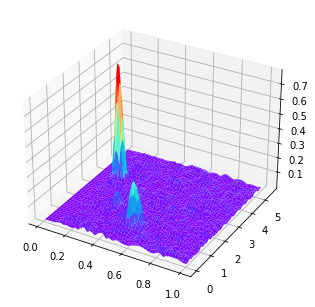

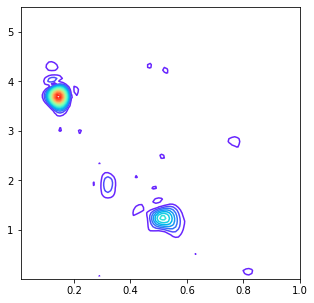

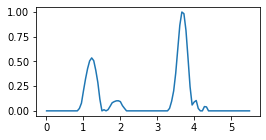

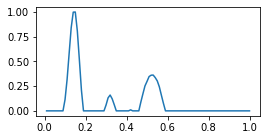

In [65]:
label_dim = 100

figure = plt.figure(0)
axes = Axes3D(figure)

X = np.linspace(0.01, 1, 100)
Y = np.linspace(0.0154, 5.5, 100)

X,Y = np.meshgrid(X, Y)
Z = test_out[0].reshape(label_dim, label_dim)
axes.plot_surface(X,Y,Z,cmap='rainbow')
plt.show()

plt.figure(1, figsize=(5, 5))
plt.contour(X, Y, Z, 20, cmap='rainbow')
plt.show()

Z[Z<0.05]=0
Z = Z / np.max(Z)
plt.figure(1, figsize=(4, 2))
plt.plot(np.linspace(0.0154, 5.5, 100), np.sum(Z, axis=1).T / np.max(np.sum(Z, axis=1)))
plt.figure(2, figsize=(4, 2))
plt.plot(np.linspace(0.01, 1, 100), np.sum(Z, axis=0).T / np.max(np.sum(Z, axis=0)))